In [1]:
using Revise

In [5]:
using BeamPropagation, 
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    Plots,
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018

In [881]:
# Define physical constants
const kB = BoltzmannConstant.val

# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const v_recoil = @with_unit 1.1 "cm/s"
;

In [882]:
Base.@kwdef struct AsymmetricGaussianTrap
    λ::Float64
    w0x::Float64
    w0y::Float64
    U_max::Float64
    m::Float64    
    zRx::Float64 = π * w0x^2 / λ
    zRy::Float64 = π * w0y^2 / λ
    ω::SVector{3, Float64} = SVector( sqrt(4*U_max/(m*w0x^2)), sqrt(4*U_max/(m*w0y^2)), sqrt(2*U_max/(m*zRx*zRy)) )
end;

In [973]:
# Define tweezer beam properties
const T_depth = @with_unit 1 "mK"
const U_max = kB * T_depth

const λ = 780e-9

const w0x = 1.9e-6
const w0y = 1.9e-6
const zRx = π * w0x^2 / λ
const zRy = π * w0y^2 / λ

# const ωx = 2π * 120e3/2
# const ωy = 2π * 120e3/2
# const ωz = sqrt(2 * U_max / (m * zRx^2))
# const ω = SVector(ωx, ωy, ωz)
trap_780nm = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
ω_crossed = SVector(trap_780nm.ω[3], trap_780nm.ω[2], trap_780nm.ω[1])
trap_780nm_crossed = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m, ω=ω_crossed)
;

In [1011]:
# Define ODT beam properties
const T_depth = @with_unit 650 "μK"
const U_max = kB * T_depth

const λ = 1064e-9

const w0x = 25e-6
const w0y = 25e-6
const zRx = π * w0x^2 / λ
const zRy = π * w0y^2 / λ

# Measured frequencies
# const ωx = 2π * 8e3/2
# const ωy = 2π * 8e3/2
# const ωz = sqrt(2 * U_max / (m * zRx^2))
# const ω = SVector(ωx, ωy, ωz)
trap_ODT = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
;

In [1012]:
# # Rydberg atom
# const T_depth = @with_unit 0.9 "mK"
# const U_max = kB * T_depth

# const λ = 809e-9
# const m = @with_unit 85.4678 "u"

# const w0x = 0.9e-6
# const w0y = 0.9e-6
# const zRx = π * w0x^2 / λ
# const zRy = π * w0y^2 / λ

# const ωx = 2π * 170e3/2
# const ωy = 2π * 170e3/2
# const ωz = sqrt(2 * U_max / (m * zRx^2))
# const ω = SVector(ωx, ωy, ωz)
# ;

### Potential and force for an ODT assuming a Gaussian beam profile

In [1044]:
wx(z, trap) = trap.w0x * sqrt(1 + z^2 / trap.zRx^2)
wy(z, trap) = trap.w0y * sqrt(1 + z^2 / trap.zRy^2)
;

In [1064]:
function F(x, y, z, trap)
    λ, w0x, w0y, zRx, zRy = trap.λ, trap.w0x, trap.w0y, trap.zRx, trap.zRy
    
    wx_ = wx(z, trap)
    wy_ = wy(z, trap)
    exp_term = exp(-2(x^2 / wx_^2 + y^2 / wy_^2))
    denom_term_x = wx_^2 * sqrt(1 + (z/zRx)^2) * sqrt(1 + (z/zRy)^2)
    denom_term_y = wy_^2 * sqrt(1 + (z/zRx)^2) * sqrt(1 + (z/zRy)^2)
    
    F_x = 4x / denom_term_x
    F_y = 4y / denom_term_y
    F_z = z * (w0x / zRx)^2 / denom_term_x + z * (w0y / zRy)^2 / denom_term_y -
        (4 * x^2 * z) / (denom_term_x * zRx^2) - (4 * y^2 * z) / (denom_term_y * zRy^2)

    return -exp_term .* SVector(F_x, F_y, F_z)
end
F(r, trap) = F(r[1], r[2], r[3], trap)
function F_crossed(r, trap)
    F_ = F(r[3], r[2], r[1], trap)
    return SVector(F_[3], F_[2], F_[1])
end
;

In [1065]:
function waist(z,w0,zR,z0)
    w0 * sqrt(1 + ((z-z0) / zR)^2)
end

function U(r, trap)
    w0x, w0y, zRx, zRy = trap.w0x, trap.w0y, trap.zRx, trap.zRy
    x, y, z = r
    
    wx = waist(z, w0x, zRx, 0)
    wy = waist(z, w0y, zRy, 0)
    return trap.U_max * (1 - ((w0x * w0y) / (wx * wy)) * exp(-2 * (x^2 / wx^2 + y^2 / wy^2)))
end;

In [1066]:
function make_distributions(T, trap)
    σ = sqrt(kB * T / m)
    σ_rx = σ / trap.ω[1]
    σ_ry = σ / trap.ω[2]
    σ_rz = σ / trap.ω[3]
    σ_vx = σ_vy = σ_vz = σ
    r = (Normal(0, σ_rx), Normal(0, σ_ry), Normal(0, σ_rz))
    v = (Normal(0, σ_vx), Normal(0, σ_vy), Normal(0, σ_vz))
    a = (Normal(0, 0), Normal(0, 0), Normal(0, 0))
    return r, v, a #, E
end
;

In [1067]:
const T = @with_unit 100 "μK"
energies = (0:0.001:20) .* (kB * T)
function cdf(E, T)
    η = E / (kB * T)
    return 1 - (1 + η + (1/2) * η^2) * exp(-η)
end
cdf_energies = [cdf(energy, T) for energy in energies]
sampler(energies, cdf_energies) = energies[searchsortedfirst(cdf_energies, rand()) ] % length(cdf_energies)
;

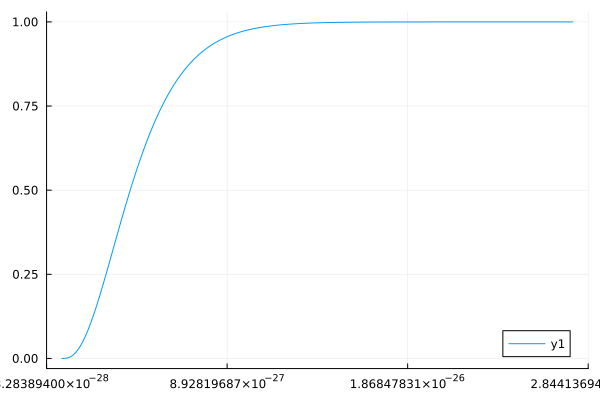

In [1068]:
plot(energies, cdf_energies)

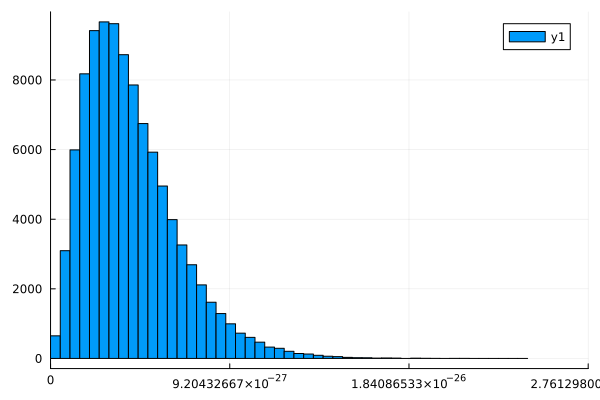

In [1069]:
histogram([sampler(energies, cdf_energies) for _ in 1:100000], bins=100, xlim=(0, 20kB * T))

In [1070]:
# Sample from position and velocity distributions for comparison
using LinearAlgebra
r, v, a = make_distributions(T, trap_780nm)
energies_ = zeros(100000)
vs = zeros(100000)
for i in 1:100000
    r0 = rand(r[1]), rand(r[2]), rand(r[3])
    v0 = rand(v[1]), rand(v[2]), rand(v[3])
    vs[i] = v0 ⋅ v0
    energies_[i] = (U(r0, trap_780nm) + (1/2) * m * (v0 ⋅ v0))
end

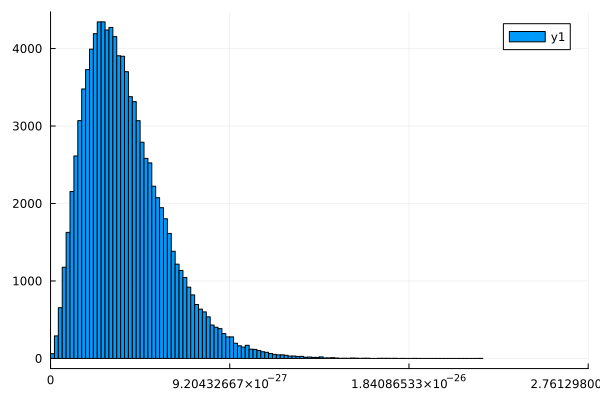

In [1071]:
histogram(energies_, bins=100, xlim=(0, 20kB * T))

In [1072]:
# function make_distributions_from_energies(T)
#     σ = sqrt(kB * T / m)
#     σ_rx = σ / ωx
#     σ_ry = σ / ωy
#     σ_rz = σ / ωz
#     σ_vx = σ_vy = σ_vz = σ
#     r = (Normal(0, σ_rx), Normal(0, σ_ry), Normal(0, σ_rz))
#     v = (Normal(0, σ_vx), Normal(0, σ_vy), Normal(0, σ_vz))
#     a = (Normal(0, 0), Normal(0, 0), Normal(0, 0))
#     return r, v, a
# end
# ;

In [1073]:
# struct HarmonicTrapEnergy <: Sampleable{Univariate, Continuous}
    # T::Float64
# end
# pdf(d, E) = exp(-E / (k_B * T)) * E^2 / (2 * (k_B * T)^3)
# logpdf(d, E) = 
# function rand(rng::AbstractRNG, 
    # sample = rand(rng, 
# function harmonic_E_dist(T)

In [1235]:
n = 100
save_every = 100
delete_every = 50
dt_min = 1e-10
dt_max = 1e-4
abstol = 1e-5
dt = 1e-7
max_steps = Int64(ceil(0.2 / dt))
alg = "rkf12"
use_adaptive = false
;

In [1236]:
function uniform_direction()
    # See https://mathworld.wolfram.com/SpherePointPicking.html
    u = 1 - 2*rand()
    θ = 2π * rand()
    return SVector(sqrt(1-u^2)*cos(θ), sqrt(1-u^2)*sin(θ), u)
end;

In [1237]:
cooling_rate(T, T_min, τ_cooling) = T > T_min ? (T_min - T) / τ_cooling : 0;

In [1238]:
# Return a linear cooling force, with damping coefficient η and offset from zero velocity by v0
linear_cooling_force(η, v, v0) = -η*(v - v0);

In [1295]:
discard(r, v) = false
is_detectable(r, trap) = (abs(r[1]) < 10trap.w0x) && (abs(r[2]) < 10trap.w0y) && (abs(r[3]) < 10 * max(trap.zRx, trap.zRy))

function update(particles, p, s, dt)
    p.time_ += dt
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[idx] = is_detectable(r, p.trap)
        
        v = particles.v[i]
        v_scalar = norm(v) / sqrt(3 * (kB * T) / m)
        scatter_prob = p.R_scatt * dt * v_scalar
        spont_recoil = v_recoil .* uniform_direction()
        if rand() < scatter_prob
            particles.v[i] += spont_recoil
        end
        # p.spont_recoil_[idx] += spont_recoil
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)

function f(idx, r, v, p)
    
#     # Calculate the force due to the cooling light
#     T_x = m * v[1]^2 / kB
#     T_y = m * v[2]^2 / kB
#     T_z = m * v[3]^2 / kB
#     # F_cooling = sign.(v) .* ((3/2) * (kB ./ norm(v)) * cooling_rate(T, p.T_min, p.τ_cooling)) # Has an overall negative sign
#     # F_cooling = ((3/2) * (kB ./ v) * cooling_rate(T, p.T_min, p.τ_cooling)) # Has an overall negative sign
#     F_cooling_x = ((3/2) * (kB ./ v[1]) * cooling_rate(T_x, p.T_min, p.τ_cooling))
#     F_cooling_y = ((3/2) * (kB ./ v[2]) * cooling_rate(T_y, p.T_min, p.τ_cooling))
#     F_cooling_z = ((3/2) * (kB ./ v[3]) * cooling_rate(T_z, p.T_min, p.τ_cooling))

    # Tweezer
    # F_cooling_x = m * linear_cooling_force(700/8, v[1], 0)
    # F_cooling_y = m * linear_cooling_force(700/8, v[2], 0)
    # F_cooling_z = m * linear_cooling_force(700/8, v[3], 0)
    
    # ODT
    F_cooling_x = m * linear_cooling_force(700, v[1], 0)
    F_cooling_y = m * linear_cooling_force(700, v[2], 0)
    F_cooling_z = m * linear_cooling_force(700, v[3], 0)
    
    # Adjust the cooling force such that it accounts for beam weights
    F_cooling = SVector(
        F_cooling_x * p.beam_weights[(sign(v[1]) == -1) + 1], 
        F_cooling_y * p.beam_weights[(sign(v[2]) == -1) + 3],
        F_cooling_z * p.beam_weights[(sign(v[3]) == -1) + 5]
        )
    
    # Calculate trapping force
    F_trap = F(r, p.trap) * p.trap.U_max / m
    # F_trap_crossed = F_crossed(r, p.trap_crossed) * U_max / m
    
    # p.spont_recoil_[idx] = F_cooling / m
    
    return F_trap + (F_cooling / m) + gravity(r)
end

function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
        push!(s.velocities[idx], particles.v[i])
        # push!(s.spont_recoil[idx], p.spont_recoil_[idx])
    end
    return nothing
end
;

In [1296]:
# Simulation parameters
# const T = @with_unit 140 "μK"
# trap_ = trap_780nm

const T = @with_unit 30 "μK"
trap_ = trap_ODT

x̂ = SVector(1,0,0)
ŷ = SVector(0,1,0)
ẑ = SVector(0,0,1)
directions = [-x̂, x̂, -ŷ, ŷ, -ẑ, ẑ]
beam_weights = Weights([1, 1, 1, 1, 1, 1])
beam_weights = Weights(beam_weights / sum(beam_weights))
beam_direction = sum(directions[i] * beam_weights[i] for i ∈ 1:6)
;

In [1297]:
using LinearAlgebra

In [1298]:
detectable = zeros(Bool, n)
time_ = 0.0

particles = StructArray{Particle}(undef, n)
trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
velocities = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
spont_recoil_ = [SVector(0.,0.,0.) for _ ∈ 1:length(particles)]
spont_recoil = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]

r, v, a = make_distributions(T, trap_)

p = MutableNamedTuple(time_=time_, R_scatt=30e3, directions=directions, beam_weights=beam_weights, trap=trap_, trap_crossed=trap_780nm_crossed, spont_recoil_=spont_recoil_)
s = MutableNamedTuple(detectable=detectable, trajectories=trajectories, velocities=velocities, spont_recoil=spont_recoil)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)
mean(s.detectable) |> display

  5.161296 seconds (123.94 k allocations: 199.356 MiB, 73.50% compilation time: 5% of which was recompilation)


0.9

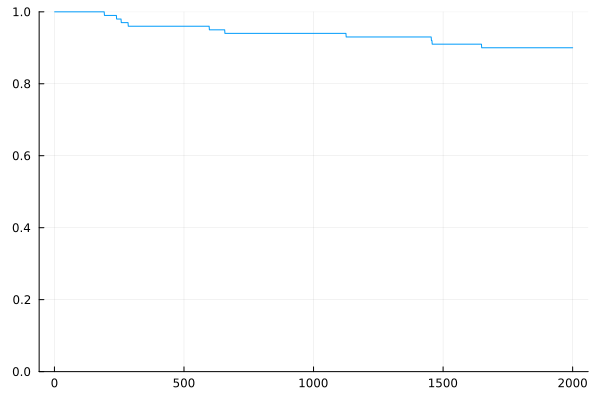

In [1299]:
survival = vec(mean(mapreduce(permutedims, vcat, [[is_detectable(s.trajectories[i][j], trap_) for j ∈ 1:10:Int(floor(max_steps/save_every))] for i ∈ 1:n]), dims=1))
plot(survival, legend=nothing, ylim=(0,1))

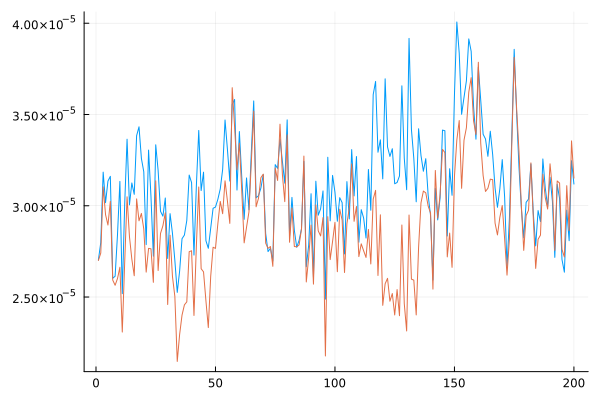

In [1300]:
temperatures = [mean([m * norm(s.velocities[i][j])^2 / (3kB) for i ∈ 1:n]) for j ∈ 1:100:Int(floor(max_steps/save_every))]
plot(temperatures, legend=nothing)
survived = findall(!iszero, [is_detectable(s.trajectories[i][end], trap_) for i ∈ 1:n])
temperatures_detectable = [mean([m * norm(s.velocities[i][j])^2 / (3kB) for i ∈ survived]) for j ∈ 1:100:Int(floor(max_steps/save_every))]
plot!(temperatures_detectable)

In [1301]:
# temperatures_x = [s.velocities[i][j][1] for j ∈ idxs]
# temperatures_y = [s.velocities[i][j][2] for j ∈ idxs]
# temperatures_z = [s.velocities[i][j][3] for j ∈ idxs]
# temperatures = [m * norm(s.velocities[i][j])^2 / (kB) for j ∈ idxs]
# plot(legend=nothing)
# # plot!(temperatures_x)
# # plot!(temperatures_y)
# # plot!(temperatures_z)
# plot!(temperatures)

In [1097]:
function differences_derivative(xs)
    ds = deepcopy(xs)
    for i ∈ eachindex(xs[1:end-1])
        ds[i] = (xs[i+1] - xs[i])
    end
    return ds
end;

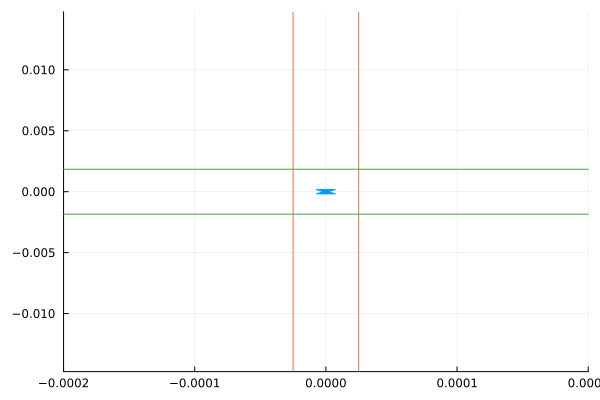

In [851]:
i = 2
idxs = 1:Int(floor((max_steps/save_every)))
plot(
    [r[1] for r ∈ s.trajectories[i]][idxs],
    [r[3] for r ∈ s.trajectories[i]][idxs],
    xlim=(-8trap_.w0x, 8trap_.w0x),
    ylim=(-8trap_.zRx, 8trap_.zRx),
    legend=nothing)
vline!([-trap_.w0x, +trap_.w0x])
hline!([-trap_.zRx, +trap_.zRx])

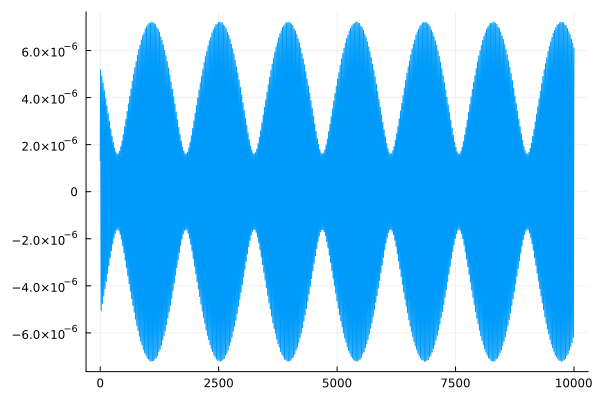

In [858]:
plot(
    [r[1] for r ∈ s.trajectories[i]][idxs],
    legend=nothing)

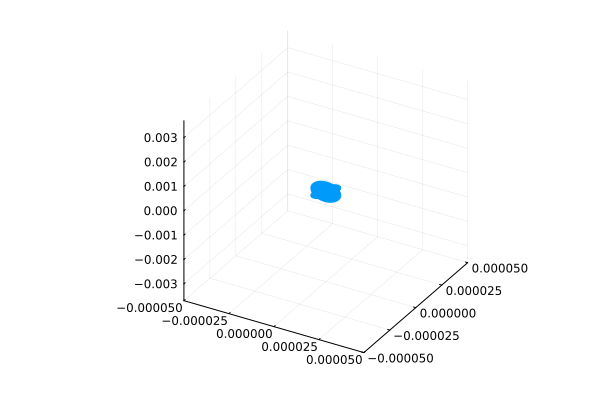

In [854]:
plot(
    [r[1] for r ∈ s.trajectories[i]][idxs], 
    [r[2] for r ∈ s.trajectories[i]][idxs],
    [r[3] for r ∈ s.trajectories[i]][idxs],
    xlim=(-2trap_.w0x, 2trap_.w0x),
    ylim=(-2trap_.w0y, 2trap_.w0y),
    zlim=(-2trap_.zRx, 2trap_.zRx),
    legend=nothing)

Do the numbers "make sense"?

The momentum imparted by recoil from spontaneous emission is given by $v_\text{recoil} = 1.1~\text{cm/s}$. Between two consecutive scattering events, this amounts to a distance travelled of 

$$d = v_\text{recoil} (1 / R_\text{scatter}) = 0.22~\mu\text{m},$$

where we used $R_\text{scatter} = 50~\text{kHz}$. For comparison, $z_R \sim 16~\mu\text{m}$ for the 780 nm tweezer trap.

In [161]:
(1/50e3) * v_recoil * 1e6

0.22000000000000003